In [ ]:
# นํา Library ที่เราต้องใช้เข้ามา

import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from google.colab import drive

from keras import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.metrics import MeanIoU
from keras.models import load_model
from keras.layers import Concatenate
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split

In [ ]:
# เช็คว่าใน Colab มี Folder ที่ชื่อว่า drive อยู่หรือไม่ ถ้าหากไม่ก็จะทําการ Mount มาจาก Google Drive

if os.path.exists('/content/drive'):
    print('google.colab.drive: The folder was already found in Google Colab, Next...')
else:
    print('google.colab.drive: The folder was not found in Google Colab, Mounting the drive...')
    drive.mount('/content/drive')

google.colab.drive: The folder was already found in Google Colab, Next...


In [ ]:
# ประกาศตัวแปรที่อยู่ของ Dataset

dataset_path = '/content/drive/MyDrive/dataset_busi_with_gt/'

In [ ]:
# Helper Function สําหรับช่วยในการหาค่าจํานวนของภาพ

def counter_helper(image):
    value = 0

    for counter in range(len(image)):
        if image[counter] == '(':
            while True:
                counter += 1

                if image[counter] == ')':
                    break
                
                value = (value * 10) + int(image[counter])
            break

    return value

In [ ]:
# ประกาศตัวแปรของ Shape ในแต่ละ Dataset

x_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
x_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
x_m, y_m = np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [ ]:
# ลูปในสําหรับการต่อ Path และเพิ่มรูปภาพเข้า Array เพื่อนําไปใช้งานในถัดๆ ไป

for counter, tumor_type in enumerate(os.listdir(dataset_path)):
    for image in os.listdir(dataset_path + tumor_type + '/'):
        path_join = os.path.join(dataset_path + tumor_type, image)
        image_cv2 = cv2.imread(path_join, cv2.IMREAD_GRAYSCALE)

        if image[-5] == ')':
            image_cv2 = cv2.resize(image_cv2, (128, 128))
            pil_image = Image.fromarray(image_cv2)

            if image[0] == 'b':
                x_b[counter_helper(image) - 1] += img_to_array(pil_image)

            if image[0] == 'n':
                x_n[counter_helper(image) - 1] += img_to_array(pil_image)

            if image[0] == 'm':
                x_m[counter_helper(image) - 1] += img_to_array(pil_image)

        else:
            image_cv2 = cv2.resize(image_cv2, (128, 128))
            pil_image = Image.fromarray(image_cv2)

            if image[0] == 'b':
                y_b[counter_helper(image) - 1] += img_to_array(pil_image)

            if image[0] == 'n':
                y_n[counter_helper(image) - 1] += img_to_array(pil_image)

            if image[0] == 'm':
                y_m[counter_helper(image) - 1] += img_to_array(pil_image)

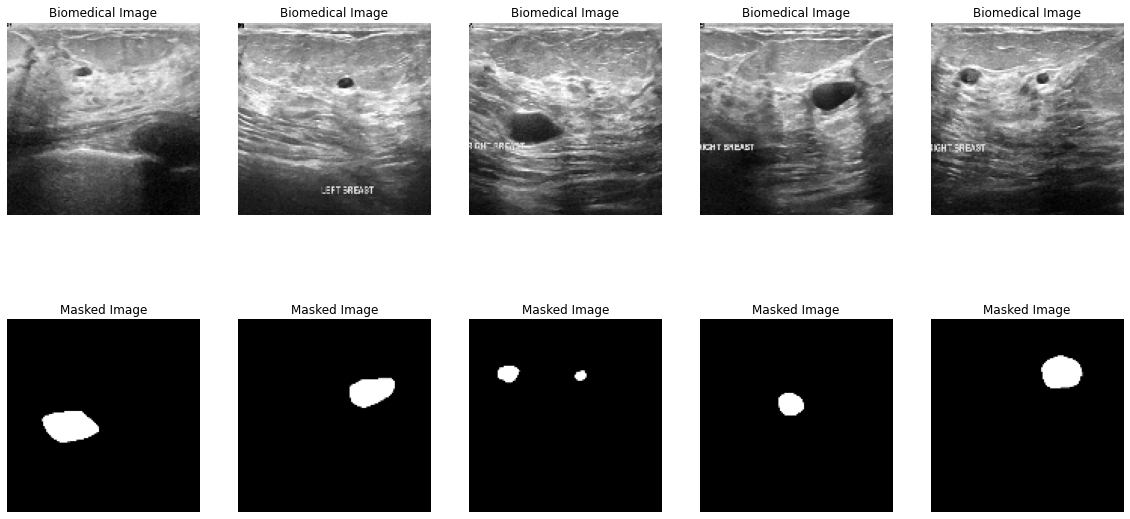

In [ ]:
# ทํา Data Exploration สําหรับโชว์ผลลัพธ์ก่อนนําไปทําการ Prediction หาก้อนเนื้อ (ภาพที่เป็นก้องเนื้อมะเร็งและภาพที่ถูก Masked ไว้ตรงก้อนเนื้อ)

plt.figure(figsize=(20, 10))

for counter in range(5):
    plt.subplot(2, 5, counter + 1)
    plt.imshow(tf.keras.utils.array_to_img(x_b[counter - 1]), 'gray')
    plt.title('Biomedical Image')
    plt.axis('off')

for counter in range(5):
    plt.subplot(2, 5, counter + 6)
    plt.imshow(tf.keras.utils.array_to_img(y_b[counter + 1]), 'gray')
    plt.title('Masked Image')
    plt.axis('off')

plt.show()

In [ ]:
# ทําการนําตัวแปรมารวมกันเป็นตัวเดียวโดยประกาศตัวแปรเป็น X กับ Y

X = np.concatenate((x_b, x_n, x_m), axis=0)
Y = np.concatenate((y_b, y_n, y_m), axis=0)

In [ ]:
X /= 255.0
Y /= 255.0

In [ ]:
# โชว์ค่า Shape ของ X และ Y

print(X.shape)
print(Y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [ ]:
# โชว์ค่าตําสุดและสูงสุดของ X

print(X.max())
print(X.min())

1.0
0.0


In [ ]:
# โชว์ค่าตําสุดและสูงสุดของ Y

print(Y.max())
print(Y.min())

2.0
0.0


In [ ]:
# จะเห็นผลลัพธ์จาก Cell ข้างบนว่าจะเป็น 2.0 ซึ่งนั่นมันผิดเราจึงต้องทําการเปลี่ยนมัน
# ให้ทําเป็น Condition ถ้าหาก Y มากกว่า 1.0 ให้ตั้งค่าให้เป็น 1.0 เลย

Y[Y > 1.0] = 1.0

In [ ]:
# โชว์ค่าตําสุดและสูงสุดของ Y

print(Y.max())
print(Y.min())

1.0
0.0


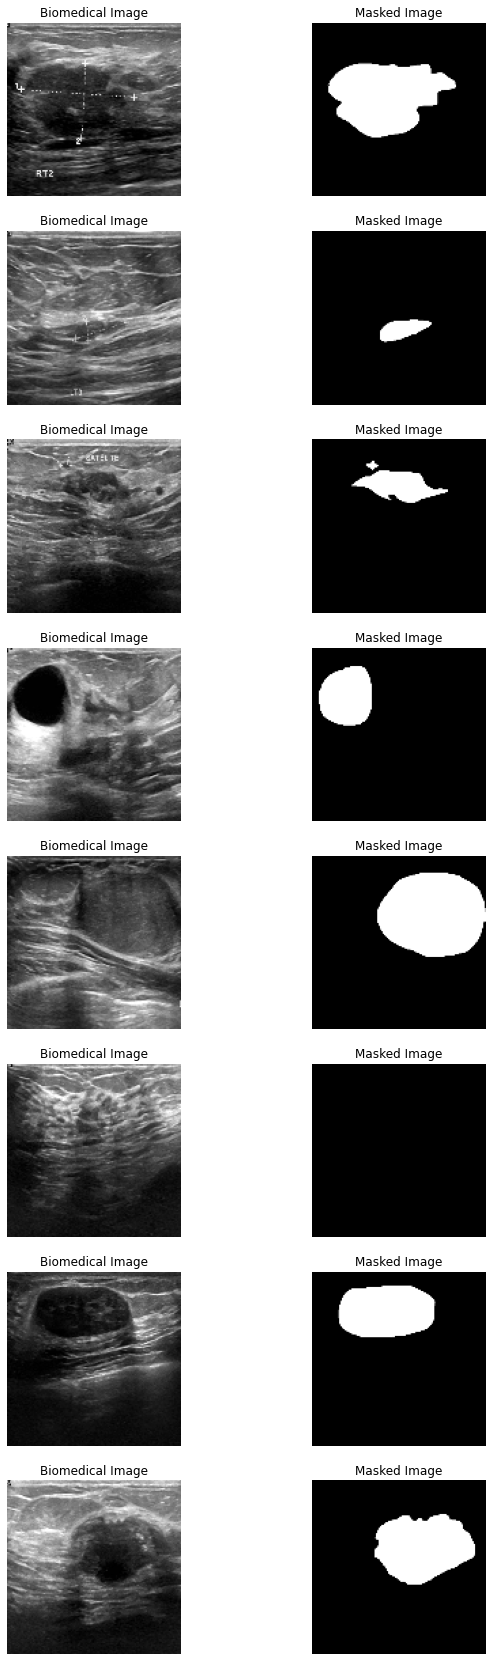

In [ ]:
# ทํา Data Exploration สําหรับโชว์ผลลัพธ์ก่อนนําไปทําการ Prediction หาก้อนเนื้อ (ภาพที่เป็นก้องเนื้อมะเร็งและภาพที่ถูก Masked ไว้ตรงก้อนเนื้อ)

plt.figure(figsize = (10,30))

counter = 0
while counter < 16:
    x = np.random.randint(0, 700)

    plt.subplot(8, 2, counter + 1)
    plt.imshow(tf.keras.utils.array_to_img(X[x]), 'gray')
    plt.title('Biomedical Image')
    plt.axis('off')

    plt.subplot(8, 2, counter + 2)
    plt.imshow(tf.keras.utils.array_to_img(Y[x]), 'gray')
    plt.title('Masked Image')
    plt.axis('off')

    counter += 2
plt.show()

In [ ]:
# แบ่งชุดข้อมูลของเราบนเทรนด์และทดสอบและเรียกใช้วิธีการตรวจสอบความถูกต้อง

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=1)

In [ ]:
# โชว์ค่า Shape ของ x_train และ y_train

print(x_train.shape)
print(y_train.shape)

(741, 128, 128, 1)
(741, 128, 128, 1)


In [ ]:
# โชว์ค่า Shape ของ x_test และ y_test

print(x_test.shape)
print(y_test.shape)

(39, 128, 128, 1)
(39, 128, 128, 1)


In [ ]:
# ทํา U-NET Architecture สําหรับใช้กับ Biomedical Image โดยเฉพาะ

input_shape = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(input_shape)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

In [ ]:
# Layer สําหรับการแก้เรื่องคอขวดของ Architecture

convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

In [ ]:
# Layer สําหรับขยาย Architecture เพื่อเพิ่มประสิทธิภาพในการ Train

tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [ ]:
# นําเข้าข้อมูลทั้งหมดลง Model เพื่อนําไปเทรนด์ต่อ

outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = input_shape, outputs = outly, name = 'U-net')

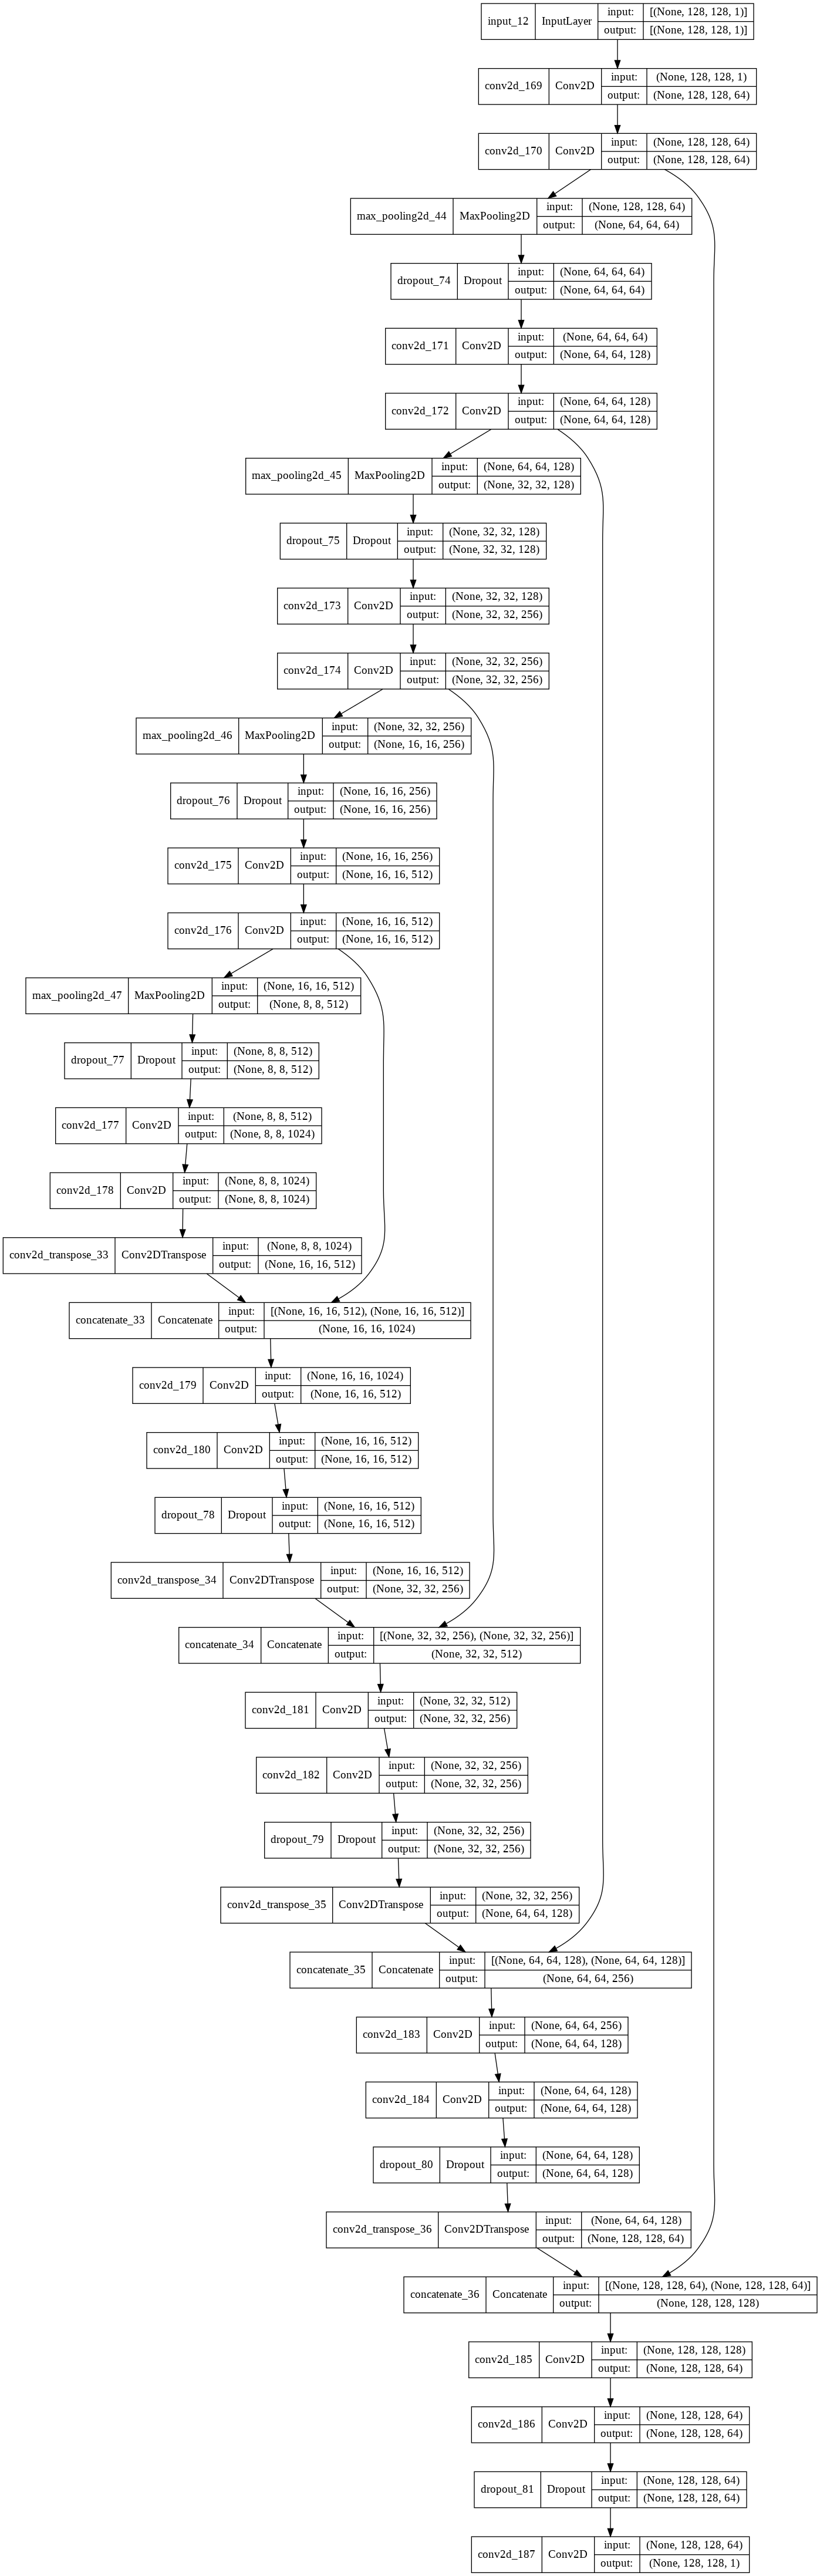

In [ ]:
# แสดง Plot จุดเชื่อมโยงต่างๆ ของ Architecture ที่เราสร้างขึ้นเพื่อ Train Model ของเรา

keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005))
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_169 (Conv2D)            (None, 128, 128, 64  640         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_170 (Conv2D)            (None, 128, 128, 64  36928       ['conv2d_169[0][0]']             
                                )                                                             

In [ ]:
# checkpoint เป็นตัวแปรควบคุมในการเทรนด์และหากการเทรนด์ประสิทธิภาพเทียบเท่า 1.0 แล้วจะทําการหยุดและไม่เทรนด์ต่อเพราะว่าการเทรนด์นั้นสูงสุดแล้ว

checkp = ModelCheckpoint(
    filepath='/tmp/checkpoint',
    save_weight_only=True,
    monitor='val_accuarcy',
    mode='max',
    save_best_only=True
)

In [ ]:
# ฟังก์ชั่นในการเริ่มการ Train ตัว Model และมีจํานวนในการเรียนรู้อยู่ที่ 100 โดยอ้างจาก epochs และแบ่ง validation ตาม shape ของ x_test และ y_test และมี callback สําหรับ checkpoint
# สําหรับเข้ามาควบคุมในการเทรนด์ตัวโมเดลหากเต็มประสิทธิภาพ

history = model.fit(x_train, y_train, epochs = 100, batch_size = 32, validation_data = (x_test, y_test), callbacks = [checkp])

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 0.0750
Epoch 00001: val_loss improved from inf to 0.07625, saving model to ./cancer_image_model.h5
24/24 [==============================] - 42s 1s/step - loss: 0.0750 - val_loss: 0.0762
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.0726
Epoch 00002: val_loss improved from 0.07625 to 0.07320, saving model to ./cancer_image_model.h5
24/24 [==============================] - 19s 790ms/step - loss: 0.0726 - val_loss: 0.0732
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.0673
Epoch 00003: val_loss improved from 0.07320 to 0.07004, saving model to ./cancer_image_model.h5
24/24 [==============================] - 19s 795ms/step - loss: 0.0673 - val_loss: 0.0700
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 0.0633
Epoch 00004: val_loss did not improve from 0.07004
24/24 [==============================] - 18s 739ms/step - loss: 0.0633 - val_loss: 0.0719
Epoc

In [ ]:
# ทําการเซฟโมเดลเพื่อนําไปใช้งานในขั้นต่อไปและแสดงผลความแม่นยําของชุดข้อมูล
model.save("./cancer_image_model.h5")
results = model.evaluate(x_test, y_test, batch_size=32)

print('\nEvaluate on the test data')
print("Test-loss, Test-accuracy: ", results)

Text(0.5, 1.0, 'Losses vs Epochs')

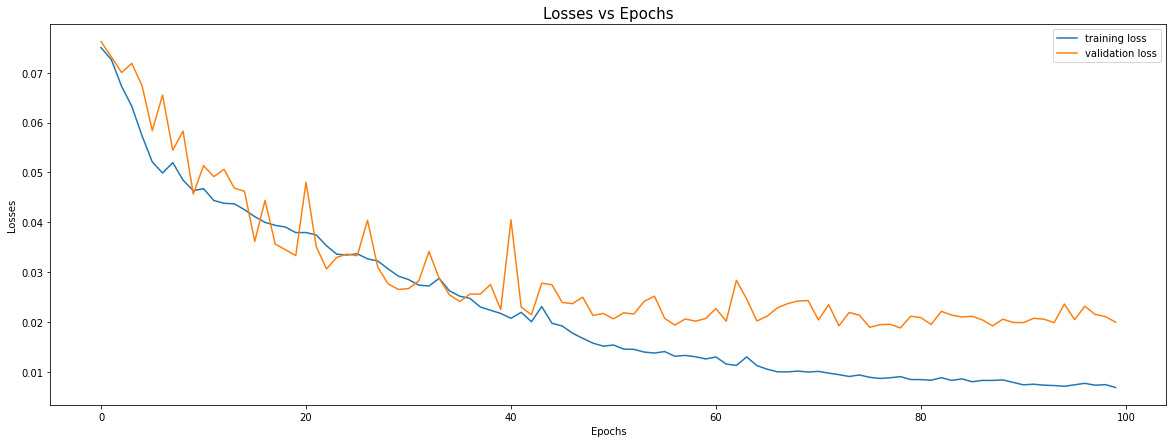

In [ ]:
# ค่าความต่างของ จํานวนที่สูญเสียไปในการ Train ของ Model
plt.figure(figsize = (20,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_los ss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses vs Epochs', fontsize = 15)

In [ ]:
# นําเข้า Model เพื่อนํามาทําการ Prediction หรือพยากรณ์

model = load_model('./cancer_image_model.h5')

In [ ]:
# ประกาศตัวแปร y_pred และนําเข้าฟังก์ชั่นในการพยากรณ์และใส่ parameter เป็น x_test เพื่อทําการพยากรณ์

y_pred = model.predict(x_test)

In [ ]:
# โชว์ค่า shape ของ y_pred

print(y_pred.shape)

(39, 128, 128, 1)


TypeError: ignored

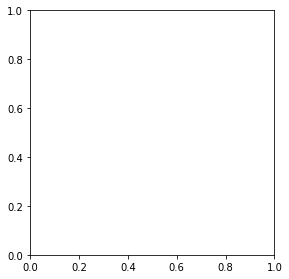

In [ ]:
# ทําการพยากรณ์ก้อนเนื้อมะเร็งเต้านมผ่าน Model ที่เราได้ Train เอาไว้

plt.figure(figsize = (20,80))

i = 0
x = 0
while i < 45 :
    
    plt.subplot(15,3,i+1)
    plt.imshow(tf.keras.utils.array_to_img(x_test[x]), 'gray')
    plt.title('Real medic Image')
    plt.axis('off')
    
    plt.subplot(15,3,i+2)
    plt.imshow(tf.keras.utils.array_to_img(y_test[x]), 'gray')
    plt.title('Ground Truth Img')
    plt.axis('off')
    
    plt.subplot(15,3,i+3)
    plt.imshow(tf.keras.utils.array_to_img(y_pred[x]), 'gray')
    plt.title('Predicited Image')
    plt.axis('off')
    
    x += 1
    i += 3
plt.show()